In [ ]:
!pip install rho-plus
!pip install matminer
!pip install scikit-learn==1.3.2

# Neural Networks: A Practical Introduction

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import rho_plus as rp

# as before: set to whichever mode you prefer
theme, cs = rp.mpl_setup(is_dark=False)

We load the dataset and compute preset descriptors. This is taken from the matminer example notebook
and not something I want to worry about right now. Instead, focus on how we learn from the data.

In [ ]:
from matminer.featurizers.conversions import StrToComposition
from matminer.featurizers.composition import ElementProperty
from matminer.featurizers.structure import DensityFeatures
from matminer.featurizers.conversions import CompositionToOxidComposition
from matminer.featurizers.composition import OxidationStates


from matminer.datasets.convenience_loaders import load_elastic_tensor
df = load_elastic_tensor()


unwanted_columns = ["volume", "nsites", "compliance_tensor", "elastic_tensor",
                    "elastic_tensor_original", "K_Voigt", "G_Voigt", "K_Reuss", "G_Reuss"]
df = df.drop(unwanted_columns, axis=1)

df = StrToComposition().featurize_dataframe(df, "formula")
ep_feat = ElementProperty.from_preset(preset_name="magpie")
df = ep_feat.featurize_dataframe(df, col_id="composition")  # input the "composition" column to the featurizer

df = CompositionToOxidComposition().featurize_dataframe(df, "composition")

os_feat = OxidationStates()
df = os_feat.featurize_dataframe(df, "composition_oxid")
df.head()

df_feat = DensityFeatures()
df = df_feat.featurize_dataframe(df, "structure")  # input the structure column to the featurizer
df

In [ ]:
df.describe()

In [ ]:
# we're predicting K_VRH
y = df['K_VRH'].values
excluded = ["G_VRH", "K_VRH", "elastic_anisotropy", "formula", "material_id",
            "poisson_ratio", "structure", "composition", "composition_oxid"]
X = df.drop(excluded, axis=1)
X = X[X.columns[X.std(axis=0) > 0]]
print('X has shape:', X.shape)
print('y has shape:', y.shape)

In [ ]:
import torch
from torch import nn
from torch.nn import functional as F

from torch.distributions.transforms import AffineTransform

mean = X.mean(axis=0)
std = X.std(axis=0)

X_aff = AffineTransform(torch.tensor(mean.values).float(), torch.tensor(std.values).float())
y_aff = AffineTransform(torch.tensor(y.mean()).float(), torch.tensor(y.std()).float())

In [ ]:
batch_size = 64
val_frac = 0.2

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader, random_split, TensorDataset

X_t = torch.from_numpy(X.values).float()
y_t = torch.from_numpy(y).float().reshape(-1, 1)

ds = TensorDataset(X_aff.inv(X_t), y_aff.inv(y_t))
train_ds, val_ds = random_split(ds, [1 - val_frac, val_frac], generator=torch.random.manual_seed(123))
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=len(val_ds))
val_X, val_y = next(iter(val_dl))

In [ ]:
class FirstNeuralNet(nn.Module):
    def __init__(self, hidden_size: int = 128, act = F.relu):
        super().__init__()

        self.fc1 = nn.Linear(X_t.shape[-1], hidden_size)
        self.fc2 = nn.Linear(hidden_size, 1)
        self.act = act

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        h = self.fc1(x)
        h = self.act(h)
        out = self.fc2(h)
        return out


X_batch, y_batch = next(iter(train_dl))

model = FirstNeuralNet()

model(X_batch).shape

In [79]:
lr = 1e-3
num_epochs = 100

hidden_size = 64
act = nn.Mish()
loss = F.mse_loss

In [80]:
from tqdm import trange

hist = []
model = FirstNeuralNet(hidden_size=hidden_size, act=act)
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)

for epoch in trange(num_epochs):
    model.train()
    loss_vals = []
    for X_batch, y_batch in train_dl:
        optimizer.zero_grad()
        loss_val = loss(model(X_batch), y_batch)
        loss_vals.append(loss_val.item())
        loss_val.backward()
        optimizer.step()
    model.eval()
    with torch.no_grad():
        val_loss = loss(model(val_X), val_y)
    hist.append({
        'Epoch': epoch,
        'Train Loss': sum(loss_vals) / len(loss_vals),
        'Validation Loss': val_loss.item()
    })

hist = pd.DataFrame(hist)

from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

val_preds = y_aff(model(val_X)).cpu().detach().numpy()
val_true = y_aff(val_y).cpu().detach().numpy()

print()
print(f'R2: \t{r2_score(val_true, val_preds):7.2%}')
print(f'MAE:\t{mean_absolute_error(val_true, val_preds):7.3f}')
print(f'RMSE:\t{mean_squared_error(val_true, val_preds, squared=False):7.3f}')

100%|██████████| 100/100 [00:00<00:00, 144.15it/s]


R2: 	 95.58%
MAE:	 10.016
RMSE:	 15.736



/home/nicholas/anaconda3/envs/aviary/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


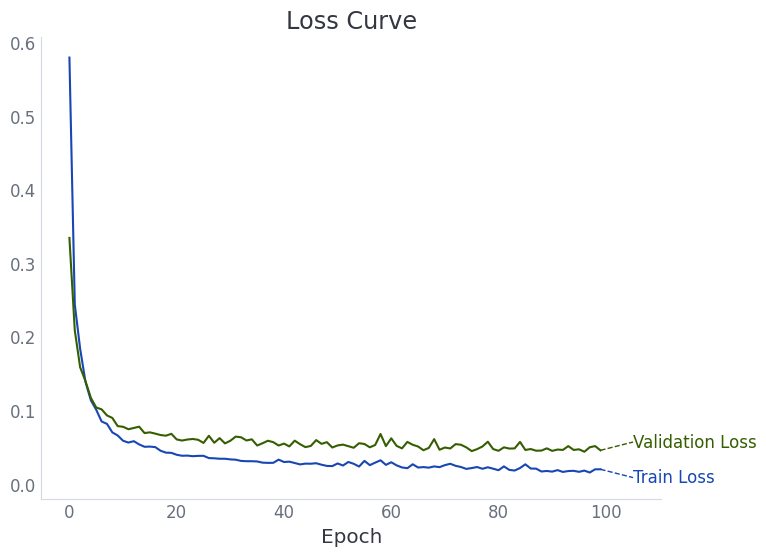

In [33]:
hist.set_index('Epoch').plot()
rp.line_labels()
plt.title('Loss Curve');

In [ ]:
fig, ax = plt.subplots(figsize=(6, 6))
ax.scatter(val_preds, val_true, alpha=0.4, s=20)
ax.set_aspect('equal')
ax.axline((0, 0), slope=1, color=plt.rcParams['axes.edgecolor'])
ax.set_xlabel('Predicted')
ax.set_ylabel('True', rotation='horizontal', ha='right')

The [Matminer example](https://nbviewer.org/github/hackingmaterials/matminer_examples/blob/main/matminer_examples/machine_learning-nb/bulk_modulus.ipynb)
I took this dataset from got significantly worse results with a random forest: R2 of 0.924, RMSE of
19.277. Go deep learning!